In [1]:
from functools import partial
from jax import numpy as jnp, random, vmap, jit
import matplotlib.pyplot as plt

import models
from filtering import filter_sweep

rk = random.PRNGKey(0)

n_players = 10
n_matches = 150

init_mean = 0
init_var = 1
tau = 5
s = 2.
epsilon = 0.

mt_key, mi_key, init_skill_key, sim_key, filter_key, init_particle_key = random.split(rk, 6)

match_times = random.uniform(mt_key, shape=(n_matches,)).sort()
mi_keys = random.split(mi_key, n_matches)
match_indices_seq = vmap(lambda rk: random.choice(rk, a=jnp.arange(n_players, ), shape=(2,), replace=False))(mi_keys)

init_player_times = jnp.zeros(n_players)
init_player_skills = init_mean + jnp.sqrt(init_var) * random.normal(init_skill_key, shape=(n_players,))

# Simulate data from trueskill model
sim_skills_p1, sim_skills_p2, sim_results = models.trueskill.simulate(init_player_times,
                                                                      init_player_skills,
                                                                      match_times,
                                                                      match_indices_seq,
                                                                      tau,
                                                                      [s, epsilon],
                                                                      sim_key)


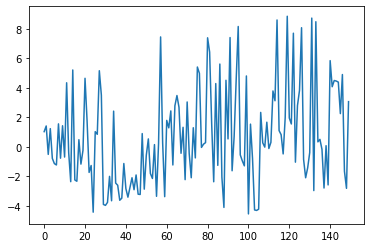

In [2]:
plt.plot(sim_skills_p1)

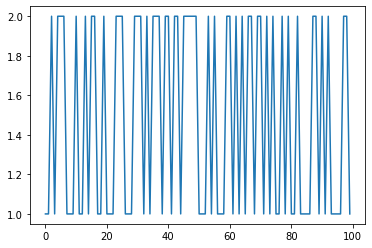

In [3]:
plt.plot(sim_results[:100])

In [4]:
models.discrete.M = 100
models.discrete.psi_computation()

m = 100
discrete_init_var = 1
discrete_tau = m
discrete_s = m / 5
epsilon = 0.

mt_key, mi_key, init_skill_key, sim_key, filter_key, init_particle_key = random.split(rk, 6)

match_times = random.uniform(mt_key, shape=(n_matches,)).sort()
# match_times = jnp.arange(1, n_matches + 1)
mi_keys = random.split(mi_key, n_matches)
match_indices_seq = vmap(lambda rk: random.choice(rk, a=jnp.arange(n_players, ), shape=(2,), replace=False))(mi_keys)

init_player_times, init_player_skills_dists = models.discrete.initiator(n_players, discrete_init_var)

init_keys = random.split(sim_key, n_players)
sampled_initial_skills \
    = vmap(lambda init_key, dist: random.choice(init_key, a=jnp.arange(models.discrete.M), p=dist)) \
    (init_keys, init_player_skills_dists)

# Simulate data from trueskill model
sim_skills_p1, sim_skills_p2, sim_results = models.discrete.simulate(init_player_times,
                                                                     sampled_initial_skills,
                                                                     match_times,
                                                                     match_indices_seq,
                                                                     discrete_tau,
                                                                     [discrete_s, epsilon],
                                                                     sim_key)

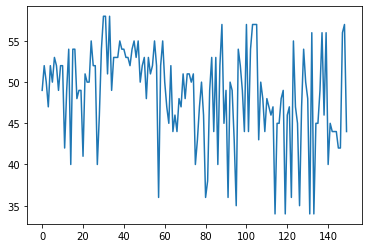

In [5]:
plt.plot(sim_skills_p1)

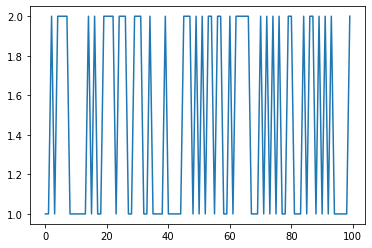

In [6]:
plt.plot(sim_results[:100])

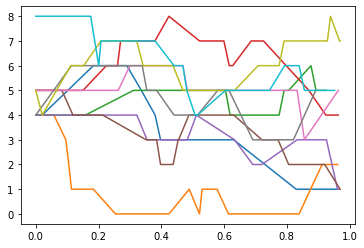

In [9]:

import smoothing

times_by_player, sim_skills_by_player = smoothing.times_and_skills_by_match_to_by_player(init_player_times,
                                                                                         sampled_initial_skills,
                                                                                         match_times,
                                                                                         match_indices_seq,
                                                                                         sim_skills_p1,
                                                                                         sim_skills_p2)

sim_skill_fig, sim_skill_ax = plt.subplots()
for tbp, ssbp in zip(times_by_player, sim_skills_by_player):
    sim_skill_ax.plot(tbp, ssbp)

mean_time_between_matches = jnp.mean(jnp.concatenate([ts[1:] - ts[:-1] for ts in times_by_player]))

In [13]:
random.PRNGKey(0)

DeviceArray([0, 0], dtype=uint32)

In [1]:
from functools import partial
from jax import numpy as jnp, random, vmap, jit
import matplotlib.pyplot as plt

import models
from filtering import filter_sweep

rk = random.PRNGKey(0)

n_players = 50
n_matches = 1500


models.discrete.M = 100
models.discrete.psi_computation()

m = models.discrete.M 
discrete_init_var = 1
discrete_tau = m
discrete_s = m / 5
epsilon = 0.

mt_key, mi_key, init_skill_key, sim_key, filter_key, init_particle_key = random.split(rk, 6)

match_times = random.uniform(mt_key, shape=(n_matches,)).sort()
# match_times = jnp.arange(1, n_matches + 1)
mi_keys = random.split(mi_key, n_matches)
match_indices_seq = vmap(lambda rk: random.choice(rk, a=jnp.arange(n_players, ), shape=(2,), replace=False))(mi_keys)

init_player_times, init_player_skills_dists = models.discrete.initiator(n_players, discrete_init_var)

init_keys = random.split(sim_key, n_players)
sampled_initial_skills \
    = vmap(lambda init_key, dist: random.choice(init_key, a=jnp.arange(models.discrete.M), p=dist)) \
    (init_keys, init_player_skills_dists)

# Simulate data from trueskill model
sim_skills_p1, sim_skills_p2, sim_results = models.discrete.simulate(init_player_times,
                                                                     sampled_initial_skills,
                                                                     match_times,
                                                                     match_indices_seq,
                                                                     discrete_tau,
                                                                     [discrete_s, epsilon],
                                                                     sim_key)

In [2]:
discrete_init_var_0 = 2
discrete_tau_0 = m/2
discrete_s = m / 5
epsilon = 0.

In [3]:
# Filter (with arbitrary parameters)
filter_sweep_data = jit(partial(filter_sweep,
                                init_player_times=jnp.zeros(n_players),
                                match_times=match_times,
                                match_player_indices_seq=match_indices_seq,
                                match_results=sim_results,
                                random_key=filter_key), static_argnums=(0,))

In [4]:
_, initial_distribution_skills_player = models.discrete.initiator(n_players, discrete_init_var_0, None)
discrete_filter_out = filter_sweep_data(models.discrete.filter,
                                        init_player_skills=initial_distribution_skills_player,
                                        static_propagate_params=discrete_tau_0,
                                        static_update_params=[discrete_s, epsilon])

In [5]:
from smoothing import smoother_sweep, times_and_skills_by_match_to_by_player

times_by_player, filter_skills_by_player = times_and_skills_by_match_to_by_player(init_player_times,
                                                                                         initial_distribution_skills_player,
                                                                                         match_times,
                                                                                         match_indices_seq,
                                                                                         discrete_filter_out[0],
                                                                                         discrete_filter_out[1])

In [6]:
discrete_smoother_skills_and_extras = [smoother_sweep(models.discrete.smoother,
                                                      times_by_player[p_ind],
                                                      filter_skills_by_player[p_ind],
                                                      discrete_tau_0,
                                                      None) for p_ind in range(len(times_by_player))]

In [14]:
smoother_skills_and_extras_by_player = discrete_smoother_skills_and_extras
match_player_indices_seq = match_indices_seq
match_results = sim_results
initial_params = discrete_init_var_0
propagate_params = discrete_tau_0
update_params = [discrete_s, epsilon]

In [15]:
update_params[1]

0.0

In [16]:
no_draw_bool = (update_params[1] == 0.) and (0 not in match_results)

In [17]:
    n_players = len(smoother_skills_and_extras_by_player)

    smoothing_list = [smoother_skills_and_extras_by_player[i][0] for i in range(n_players)]
    grad_smoothing_list = [smoother_skills_and_extras_by_player[i][1] for i in range(n_players)]

    initial_smoothing_dists = jnp.array([smoothing_list[i][0] for i in range(n_players)])

In [18]:
_, initial_distribution_skills_player = models.discrete.initiator(n_players, discrete_init_var_0, None)

In [27]:
    def negative_expected_log_intial(log_rate):
        rate = jnp.exp(log_rate)
        _, initial_distribution_skills_player = models.discrete.initiator(n_players, rate, None)

        return -jnp.sum(jnp.log(initial_distribution_skills_player)*initial_smoothing_dists)

In [28]:
from scipy.optimize import minimize

In [31]:
jnp.log(initial_params)

DeviceArray(0.6931472, dtype=float32, weak_type=True)

In [29]:
optim_res = minimize(negative_expected_log_intial, jnp.log(initial_params), method='cobyla')

In [30]:
optim_res

     fun: 93.2418212890625
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 18
  status: 1
 success: True
       x: array([0.78689718])

In [ ]:
p_ind = 0
import time

start = time.time()
try_this = smoother_sweep(models.discrete.smoother, times_by_player[p_ind], sim_skills_by_player[p_ind], discrete_tau, None)
print(time.time()-start)

0.6653289794921875


In [13]:
p_ind = 0
import time

start = time.time()
try_this = smoother_sweep(models.discrete.smootherM3, times_by_player[p_ind], sim_skills_by_player[p_ind], discrete_tau, None)
print(time.time()-start)

4.015218734741211


In [6]:
discrete_smoother_skills_and_extras_old = [smoother_sweep(models.discrete.smootherM3,
                                                      times_by_player[p_ind],
                                                      sim_skills_by_player[p_ind],
                                                      discrete_tau,
                                                      None) for p_ind in range(len(times_by_player))]

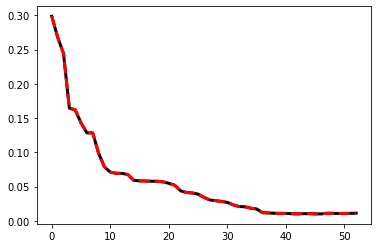

In [11]:
skill = 50
player= 10
plt.plot(discrete_smoother_skills_and_extras[player][0][:,skill], "black", linewidth = 3)
plt.plot(discrete_smoother_skills_and_extras_old[player][0][:,skill],  "red", linestyle = "--", linewidth = 3)

In [8]:
discrete_smoother_skills_and_extras_old[0][0][-10:,0]

DeviceArray([9.4640245e-14, 2.1523101e-15, 1.5264190e-15, 9.3984250e-13,
             3.5341875e-11, 2.0005930e-10, 3.9289613e-08, 1.2770030e-07,
             2.6838387e-07, 3.9911654e-07], dtype=float32)

In [42]:
jnp.where(discrete_smoother_skills_and_extras[0][0][-10:,:]<=0)

(DeviceArray([3], dtype=int32), DeviceArray([9], dtype=int32))

In [43]:
discrete_smoother_skills_and_extras[0][0][-10:,9]

DeviceArray([           nan,            nan,            nan,
             -1.4677006e-08,  1.7073448e-10,  1.3377778e-10,
              1.7751241e-10,  1.9060468e-10,  7.9967200e-10,
              3.4680327e-09], dtype=float32)

In [8]:
elo_filter_out = filter_sweep_data(models.elo.filter,
                                   init_player_skills=init_player_skills,
                                   static_propagate_params=None, static_update_params=[1., 1.])

In [9]:
init_player_skills_and_var = jnp.vstack([init_player_skills, jnp.ones(n_players)]).T
glicko_filter_out = filter_sweep_data(models.glicko.filter,
                                      init_player_skills=init_player_skills_and_var,
                                      static_propagate_params=[1., 350 ** 2], static_update_params=None)

In [10]:
trueskill_filter_out = filter_sweep_data(models.trueskill.filter,
                                         init_player_skills=init_player_skills_and_var,
                                         static_propagate_params=tau, static_update_params=[s, epsilon])

In [11]:
n_particles = 100
init_player_skills_particles = init_player_skills.reshape(n_players, 1) \
                               + jnp.sqrt(init_var) * random.normal(init_particle_key, shape=(n_players, n_particles))
lsmc_filter_out = filter_sweep_data(models.lsmc.filter,
                                    init_player_skills=init_player_skills_particles,
                                    static_propagate_params=tau, static_update_params=[s, epsilon])

In [12]:
models.discrete.M = 100
models.discrete.psi_computation()

initial_distribution_skills = jnp.zeros(models.discrete.M)
initial_distribution_skills = initial_distribution_skills.at[0].set(0.8)
initial_distribution_skills = initial_distribution_skills.at[1].set(0.2)

epsilon_disc = 2
s_disc = 2

_, initial_distribution_skills_player = models.discrete.initiator(n_players, initial_distribution_skills, rk)
discrete_filter_out = filter_sweep_data(models.discrete.filter,
                                        init_player_skills=initial_distribution_skills_player,
                                        static_propagate_params=tau, static_update_params=[s_disc, epsilon_disc])

0 0 Trueskill -inf 1.5985925
0 0 LSMC -inf 2.127729
1 0 Trueskill -inf 0.0
1 0 LSMC -inf 0.15159726
2 0 Trueskill -inf 0.0009975433
2 0 LSMC -707.484 0.14860272
3 0 Trueskill -938.78314 0.0009977818
3 0 LSMC -637.30835 0.15058589
4 0 Trueskill -767.7855 0.0
4 0 LSMC -609.0929 0.15155554
5 0 Trueskill -687.8592 0.0009930134
5 0 LSMC -602.09454 0.14959979
6 0 Trueskill -645.3521 0.0
6 0 LSMC -589.06555 0.15059662
7 0 Trueskill -621.26587 0.0009937286
7 0 LSMC -592.447 0.15059853
8 0 Trueskill -607.3926 0.0009977818
8 0 LSMC -595.59937 0.14760566
9 0 Trueskill -599.684 0.0
9 0 LSMC -592.48804 0.15259266
10 0 Trueskill -595.9436 0.0
10 0 LSMC -601.51196 0.14860201
11 0 Trueskill -594.8898 0.0009980202
11 0 LSMC -604.5831 0.15456176
12 0 Trueskill -595.72974 0.0
12 0 LSMC -605.16345 0.15059733
13 0 Trueskill -597.9489 0.0009982586
13 0 LSMC -611.1958 0.14959836
14 0 Trueskill -601.199 0.0
14 0 LSMC -616.2087 0.14957023
15 0 Trueskill -605.2354 0.0
15 0 LSMC -628.9668 0.15371561
16 0 Trueski

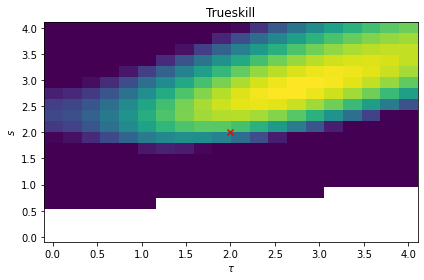

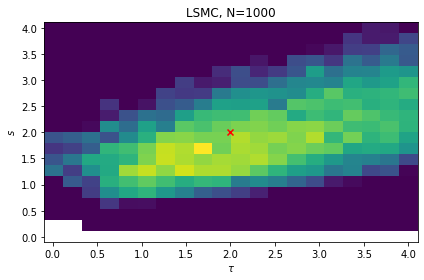

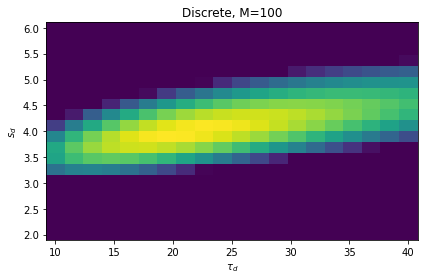

In [17]:
%run -i simulate_and_filter_tune_s_tau.py

0 0 Trueskill -558.77716 1.6321511
0 0 LSMC -579.0416 2.248129
1 0 Trueskill -604.41077 0.0
1 0 LSMC -627.41016 0.15159488
2 0 Trueskill -649.85254 0.0009977818
2 0 LSMC -660.6697 0.15963817
3 0 Trueskill -692.5294 0.0
3 0 LSMC -703.0564 0.16304874
4 0 Trueskill -731.37024 0.00096416473
4 0 LSMC -732.7388 0.16276526
5 0 Trueskill -766.0418 0.0009958744
5 0 LSMC -758.3098 0.15753865
6 0 Trueskill -796.6135 0.0
6 0 LSMC -791.5137 0.15259433
7 0 Trueskill -823.3677 0.0009970665
7 0 LSMC -812.1359 0.15059733
8 0 Trueskill -846.68335 0.0010271072
8 0 LSMC -835.4612 0.14960027
9 0 Trueskill -866.9663 0.0
9 0 LSMC -849.9809 0.15891147
10 0 Trueskill -884.61 0.0
10 0 LSMC -871.3339 0.14860034
11 0 Trueskill -899.9756 0.0009973049
11 0 LSMC -882.0958 0.1514461
12 0 Trueskill -913.38416 0.0009982586
12 0 LSMC -895.9606 0.1579771
13 0 Trueskill -925.1152 0.0009949207
13 0 LSMC -901.16296 0.15059686
14 0 Trueskill -935.4089 0.0
14 0 LSMC -916.39844 0.14960027
15 0 Trueskill -944.4701 0.0009977818


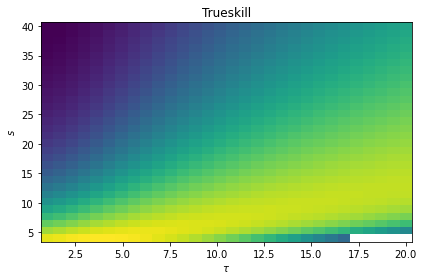

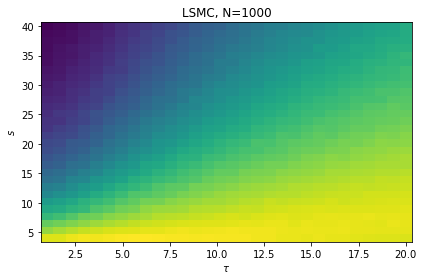

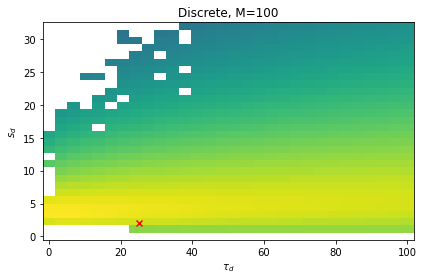

In [25]:
%run -i simulate_and_filter_tune_s_tau_discrete.py

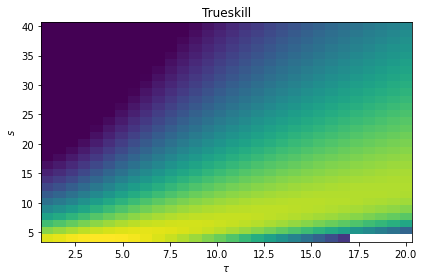

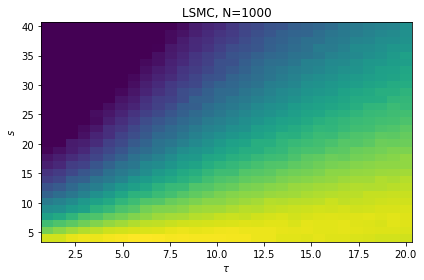

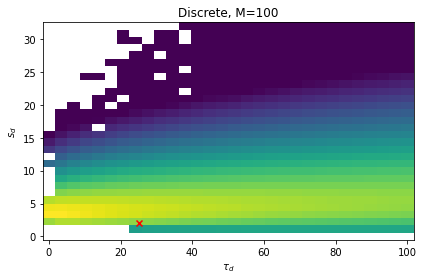

In [29]:
trueskill_mls = jnp.load('data/trueskill_mls_discrete.npy')
trueskill_times = jnp.load('data/trueskill_times_discrete.npy')
lsmc_mls = jnp.load('data/lsmc_mls_discrete.npy')
lsmc_times = jnp.load('data/lsmc_times_discrete.npy')
discrete_mls = jnp.load('data/discrete_mls_discrete.npy')
discrete_times = jnp.load('data/discrete_times_discrete.npy')


ts_fig, ts_ax = plt.subplots()
ts_ax.pcolormesh(tau_linsp, s_linsp, trueskill_mls, vmin = -900)
ts_ax.set_title('Trueskill')
ts_ax.set_xlabel('$\\tau$')
ts_ax.set_ylabel('$s$')
ts_fig.tight_layout()

lsmc_fig, lsmc_ax = plt.subplots()
lsmc_ax.pcolormesh(tau_linsp, s_linsp, lsmc_mls, vmin = -900)
lsmc_ax.set_title(f'LSMC, N={n_particles}')
lsmc_ax.set_xlabel('$\\tau$')
lsmc_ax.set_ylabel('$s$')
lsmc_fig.tight_layout()


discrete_fig, discrete_ax = plt.subplots()
discrete_ax.pcolormesh(discrete_tau_linsp, discrete_s_linsp, discrete_mls, vmin = -700)
discrete_ax.scatter(tau, s_disc, c='red', marker='x')
discrete_ax.set_title(f'Discrete, M={m}')
discrete_ax.set_xlabel('$\\tau_d$')
discrete_ax.set_ylabel('$s_d$')
discrete_fig.tight_layout()

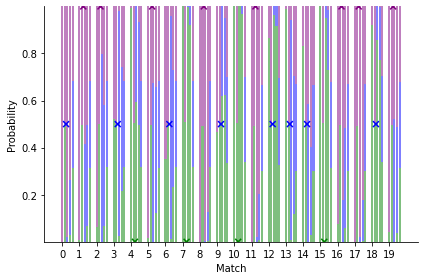

In [3]:
# Plot results
n_matches_plot = 20
bin_width = 0.15
inds = jnp.arange(n_matches_plot)
alph = 0.5


def plot_predictions(ax, predictions, barpos):
    ax.bar(inds + barpos * bin_width, predictions[:, 2], bottom=1 - predictions[:, 2], width=bin_width * 0.8,
           color='purple', alpha=alph)  # p2 wins
    ax.bar(inds + barpos * bin_width, predictions[:, 0], bottom=predictions[:, 1], width=bin_width * 0.8, color='blue',
           alpha=alph)  # draw
    ax.bar(inds + barpos * bin_width, predictions[:, 1], bin_width * 0.8, color='green', alpha=alph)  # p1 wins


fig, ax = plt.subplots()
plot_predictions(ax, elo_filter_out[-1][:n_matches_plot], 0)
plot_predictions(ax, glicko_filter_out[-1][:n_matches_plot], 1)
plot_predictions(ax, trueskill_filter_out[-1][:n_matches_plot], 2)
plot_predictions(ax, lsmc_filter_out[-1][:n_matches_plot], 3)
plot_predictions(ax, discrete_filter_out[-1][:n_matches_plot], 4)
ax.set_xticks(jnp.arange(n_matches_plot))

res_cols = [['blue', 'green', 'purple'][r] for r in sim_results[:n_matches_plot]]
res_to_probpos = {0: 0.5, 1: 0, 2: 1}
res_probs = [res_to_probpos[int(r)] for r in sim_results[:n_matches_plot]]
ax.scatter(inds + bin_width * 1.5, res_probs, c=res_cols, marker='x')
ax.set_xlabel('Match')
ax.set_ylabel('Probability')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.tight_layout()

fix s and plot image on the others (on synthetic and real data[discard 2020, use 2021 train and 2022 for test])

In [4]:
grid_size = 20

tau_grid = jnp.linspace(0.2, 2, grid_size)

log_likelihood = jnp.zeros(grid_size)

for j in range(grid_size):
    initial_distribution_skills = jnp.zeros(10)
    initial_distribution_skills = initial_distribution_skills.at[0].set(0.8)
    initial_distribution_skills = initial_distribution_skills.at[1].set(0.2)

    tau_current = tau_grid[j]

    _, initial_distribution_skills_player = models.discrete.initiator(n_players, initial_distribution_skills, rk)
    discrete_filter_out = filter_sweep_data(models.discrete.filter,
                                            init_player_skills=initial_distribution_skills_player,
                                            static_propagate_params=tau_current, static_update_params=[s, epsilon/2])

    log_likelihood = log_likelihood.at[j].set(sum([jnp.log(discrete_filter_out[-1][i,sim_results[i]]) for i in range(len(sim_results))]))

Text(0.5, 0, '$\\tau$')

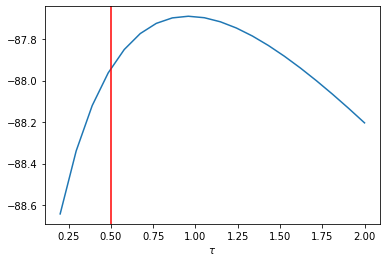

In [5]:
plt.plot(tau_grid, log_likelihood)
plt.axvline(tau, color = "red")
plt.xlabel(r"$\tau$")

In [6]:
grid_size = 20

s_disc_current_grid = jnp.linspace(0.5, 3, grid_size)

log_likelihood = jnp.zeros(grid_size)

for j in range(grid_size):
    initial_distribution_skills = jnp.zeros(10)
    initial_distribution_skills = initial_distribution_skills.at[0].set(0.8)
    initial_distribution_skills = initial_distribution_skills.at[1].set(0.2)

    s_disc_current = s_disc_current_grid[j]

    _, initial_distribution_skills_player = models.discrete.initiator(n_players, initial_distribution_skills, rk)
    discrete_filter_out = filter_sweep_data(models.discrete.filter,
                                            init_player_skills=initial_distribution_skills_player,
                                            static_propagate_params=tau, static_update_params=[s_disc_current, epsilon/2])

    log_likelihood = log_likelihood.at[j].set(sum([jnp.log(discrete_filter_out[-1][i,sim_results[i]]) for i in range(len(sim_results))]))

Text(0.5, 0, '$s$')

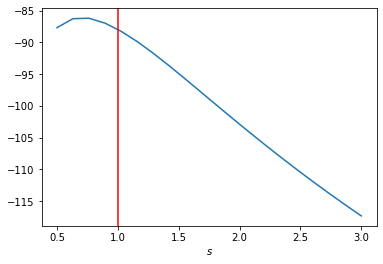

In [7]:
plt.plot(s_disc_current_grid, log_likelihood)
plt.axvline(s, color = "red")
plt.xlabel(r"$s$")

In [8]:
grid_size = 20

epsilon_current_grid = jnp.linspace(0.5, 3, grid_size)

log_likelihood = jnp.zeros(grid_size)

for j in range(grid_size):
    initial_distribution_skills = jnp.zeros(10)
    initial_distribution_skills = initial_distribution_skills.at[0].set(0.8)
    initial_distribution_skills = initial_distribution_skills.at[1].set(0.2)

    epsilon_current = epsilon_current_grid[j]

    _, initial_distribution_skills_player = models.discrete.initiator(n_players, initial_distribution_skills, rk)
    discrete_filter_out = filter_sweep_data(models.discrete.filter,
                                            init_player_skills=initial_distribution_skills_player,
                                            static_propagate_params=tau, static_update_params=[s, epsilon_current])

    log_likelihood = log_likelihood.at[j].set(sum([jnp.log(discrete_filter_out[-1][i,sim_results[i]]) for i in range(len(sim_results))]))

Text(0.5, 0, '$\\epsilon$')

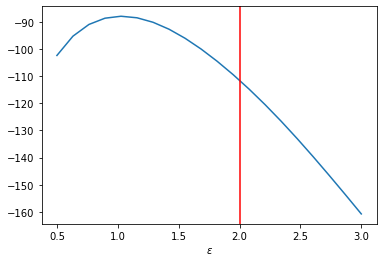

In [9]:
plt.plot(epsilon_current_grid, log_likelihood)
plt.axvline(epsilon, color = "red")
plt.xlabel(r"$\epsilon$")

In [10]:
tau_grid = jnp.linspace(0.1, 4, grid_size)
s_grid   = jnp.linspace(0.1, 3, grid_size)

tau_grid_mesh, s_grid_mesh = jnp.meshgrid(tau_grid, s_grid)

log_likelihood_tau_s = jnp.zeros(tau_grid_mesh.shape)

for j1 in range(tau_grid_mesh.shape[0]):
    for j2 in range(tau_grid_mesh.shape[1]):
        initial_distribution_skills = jnp.zeros(10)
        initial_distribution_skills = initial_distribution_skills.at[0].set(0.8)
        initial_distribution_skills = initial_distribution_skills.at[1].set(0.2)

        tau_current = tau_grid_mesh[j1, j2]
        s_current  = s_grid_mesh[j1, j2]

        _, initial_distribution_skills_player = models.discrete.initiator(n_players, initial_distribution_skills, rk)
        discrete_filter_out = filter_sweep_data(models.discrete.filter,
                                                init_player_skills=initial_distribution_skills_player,
                                                static_propagate_params=tau_current, static_update_params=[s_current, epsilon/2])

        log_likelihood_tau_s = log_likelihood_tau_s.at[j1,j2].set(sum([jnp.log(discrete_filter_out[-1][i,sim_results[i]]) for i in range(len(sim_results))]))

Text(0.5, 0, '$\\tau$')

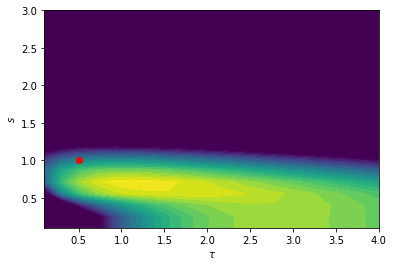

In [11]:
plt.contourf(tau_grid, s_grid, log_likelihood_tau_s, levels=200, vmin = -90)
plt.scatter([tau], [s], color = "red")

plt.ylabel(r"$s$")
plt.xlabel(r"$\tau$")

In [12]:
tau_grid     = jnp.linspace(0.1, 4, grid_size)
epsilon_grid = jnp.linspace(0.1, 3, grid_size)

tau_grid_mesh, epsilon_mesh = jnp.meshgrid(tau_grid, epsilon_grid)

log_likelihood = jnp.zeros(tau_grid_mesh.shape)

for j1 in range(tau_grid_mesh.shape[0]):
    for j2 in range(tau_grid_mesh.shape[1]):
        initial_distribution_skills = jnp.zeros(10)
        initial_distribution_skills = initial_distribution_skills.at[0].set(0.8)
        initial_distribution_skills = initial_distribution_skills.at[1].set(0.2)

        tau_current = tau_grid_mesh[j1, j2]
        epsilon_current  = epsilon_mesh[j1, j2]

        _, initial_distribution_skills_player = models.discrete.initiator(n_players, initial_distribution_skills, rk)
        discrete_filter_out = filter_sweep_data(models.discrete.filter,
                                                init_player_skills=initial_distribution_skills_player,
                                                static_propagate_params=tau_current, static_update_params=[s, epsilon_current])

        log_likelihood = log_likelihood.at[j1,j2].set(sum([jnp.log(discrete_filter_out[-1][i,sim_results[i]]) for i in range(len(sim_results))]))

Text(0.5, 0, '$\\tau$')

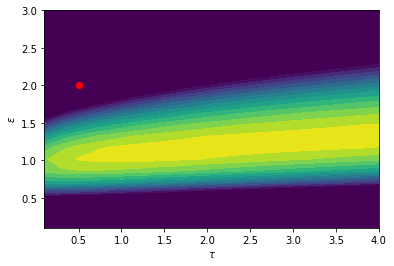

In [13]:
plt.contourf(tau_grid_mesh, epsilon_mesh, log_likelihood, levels=100, vmin = -100)
plt.scatter([tau], [epsilon], color = "red")

plt.ylabel(r"$\epsilon$")
plt.xlabel(r"$\tau$")

In [10]:
from jax import numpy as jnp, random, vmap
import matplotlib.pyplot as plt

import models
from filtering import filter_sweep
from smoothing import smoother_sweep, times_and_skills_by_match_to_by_player

rk = random.PRNGKey(0)

n_players = 50
n_matches = 1000

init_mean = 0.
init_var = 3.
tau = 0.5
s = 1.
epsilon = 2.

mt_key, mi_key, init_skill_key, sim_key, filter_key, init_particle_key = random.split(rk, 6)

# match_times = random.uniform(mt_key, shape=(n_matches,)).sort()
match_times = jnp.arange(1, n_matches + 1)
mi_keys = random.split(mi_key, n_matches)
match_indices_seq = vmap(lambda rk: random.choice(rk, a=jnp.arange(n_players, ), shape=(2,), replace=False))(mi_keys)

init_player_times = jnp.zeros(n_players)
init_player_skills = init_mean + jnp.sqrt(init_var) * random.normal(init_skill_key, shape=(n_players,))

# Simulate data from trueskill model
sim_skills_p1, sim_skills_p2, sim_results = models.trueskill.simulate(init_player_times,
                                                                      init_player_skills,
                                                                      match_times,
                                                                      match_indices_seq,
                                                                      tau,
                                                                      [s, epsilon],
                                                                      sim_key)

print(f'Prop draws = {(sim_results == 0).mean() * 100:.2f}%')

true_times_by_player, true_skills_by_player = times_and_skills_by_match_to_by_player(init_player_times,
                                                                                     init_player_skills,
                                                                                     match_times,
                                                                                     match_indices_seq,
                                                                                     sim_skills_p1,
                                                                                     sim_skills_p2)

init_mean_and_var = jnp.array([init_mean, init_var])
init_tau = tau
init_s_and_epsilon = jnp.array([s, epsilon])

# TrueSkill (EP) filter and smooth
trueskill_init_times, trueskill_init_skills = models.trueskill.initiator(n_players, init_mean_and_var)
trueskill_filter_out = filter_sweep(models.trueskill.filter,
                                    trueskill_init_times, trueskill_init_skills,
                                    match_times, match_indices_seq, sim_results, init_tau, init_s_and_epsilon)

trueskill_times_by_player, trueskill_filter_skills_by_player = times_and_skills_by_match_to_by_player(
    trueskill_init_times,
    trueskill_init_skills,
    match_times,
    match_indices_seq,
    trueskill_filter_out[0],
    trueskill_filter_out[1])
trueskill_smoother_skills_and_extras = [smoother_sweep(models.trueskill.smoother,
                                                       trueskill_times_by_player[p_ind],
                                                       trueskill_filter_skills_by_player[p_ind],
                                                       init_tau,
                                                       None) for p_ind in range(len(trueskill_times_by_player))]

# TrueSkill (SMC) filter and smooth
models.lsmc.n_particles = 100
lsmc_init_times, lsmc_init_skills = models.lsmc.initiator(n_players, init_mean_and_var, rk)
lsmc_filter_out = filter_sweep(models.lsmc.filter,
                               lsmc_init_times, lsmc_init_skills,
                               match_times, match_indices_seq, sim_results, init_tau, init_s_and_epsilon)

lsmc_times_by_player, lsmc_filter_skills_by_player = times_and_skills_by_match_to_by_player(lsmc_init_times,
                                                                                            lsmc_init_skills,
                                                                                            match_times,
                                                                                            match_indices_seq,
                                                                                            lsmc_filter_out[0],
                                                                                            lsmc_filter_out[1])
lsmc_smoother_skills_and_extras = [smoother_sweep(models.lsmc.smoother,
                                                  lsmc_times_by_player[p_ind],
                                                  lsmc_filter_skills_by_player[p_ind],
                                                  init_tau,
                                                  None) for p_ind in range(len(lsmc_times_by_player))]

# Discrete filter and smooth
m = 100
discrete_init_times, discrete_init_skills = models.discrete.initiator(n_players, jnp.ones(m) / m)
discrete_filter_out = filter_sweep(models.discrete.filter,
                                   discrete_init_times, discrete_init_skills,
                                   match_times, match_indices_seq, sim_results, init_tau, init_s_and_epsilon)

discrete_times_by_player, discrete_filter_skills_by_player \
    = times_and_skills_by_match_to_by_player(discrete_init_times,
                                             discrete_init_skills,
                                             match_times,
                                             match_indices_seq,
                                             discrete_filter_out[0],
                                             discrete_filter_out[1])

discrete_smoother_skills_and_extras = [smoother_sweep(models.discrete.smoother,
                                                      discrete_times_by_player[p_ind],
                                                      discrete_filter_skills_by_player[p_ind],
                                                      init_tau,
                                                      None) for p_ind in range(len(lsmc_times_by_player))]


# # Plot filtering
# for i in range(min(n_players, 5)):
#     fig, ax = plt.subplots()
#     ax.plot(true_times_by_player[i], true_skills_by_player[i], color='red', label='Truth', zorder=100)
#     ts_mn = trueskill_filter_skills_by_player[i][:, 0]
#     ts_sd = jnp.sqrt(trueskill_filter_skills_by_player[i][:, 1])
#     ax.fill_between(trueskill_times_by_player[i], ts_mn - ts_sd, ts_mn + ts_sd, color='blue', alpha=0.25, linewidth=0)
#     ax.plot(trueskill_times_by_player[i], ts_mn, color='blue', label='TrueSkill')
#
#     lsmc_mn = lsmc_filter_skills_by_player[i].mean(1)
#     lsmc_std = jnp.std(lsmc_filter_skills_by_player[i], axis=1)
#     ax.fill_between(lsmc_times_by_player[i], lsmc_mn - lsmc_std, lsmc_mn + lsmc_std,
#                     color='green', alpha=0.25, linewidth=0)
#     ax.plot(lsmc_times_by_player[i], lsmc_mn, color='green', label='SMC')
#     ax_d = ax.twinx()
#     d_mn = (jnp.arange(m) * discrete_filter_skills_by_player[i]).sum(1)
#     ax_d.plot(discrete_times_by_player[i], d_mn, color='orange', label='Discrete')
#
#     ax.legend(loc='upper left')
#     ax_d.legend(loc='upper right')




Prop draws = 10.40%


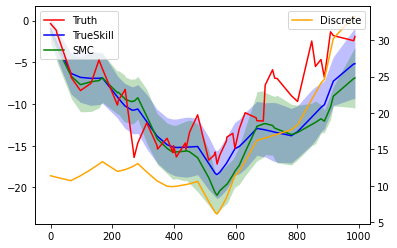

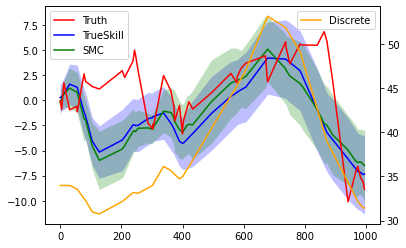

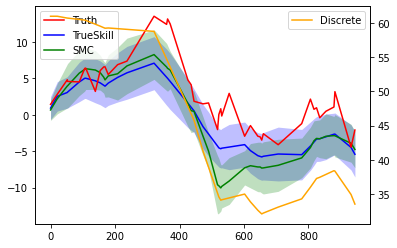

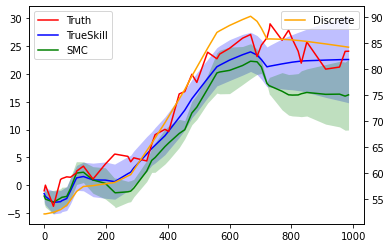

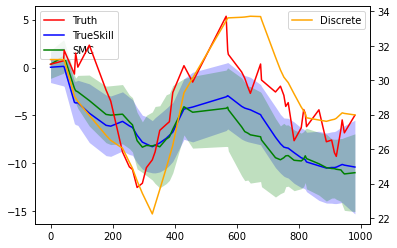

In [12]:
# Plot smoothing
for i in range(min(n_players, 5)):
    fig, ax = plt.subplots()
    ax.plot(true_times_by_player[i], true_skills_by_player[i], color='red', label='Truth', zorder=100)
    ts_mn = trueskill_smoother_skills_and_extras[i][0][:, 0]
    ts_sd = jnp.sqrt(trueskill_smoother_skills_and_extras[i][0][:, 1])
    ax.fill_between(trueskill_times_by_player[i], ts_mn - ts_sd, ts_mn + ts_sd, color='blue', alpha=0.25, linewidth=0)
    ax.plot(trueskill_times_by_player[i], ts_mn, color='blue', label='TrueSkill')

    lsmc_mn = lsmc_smoother_skills_and_extras[i][0].mean(1)
    lsmc_std = jnp.std(lsmc_smoother_skills_and_extras[i][0], axis=1)
    ax.fill_between(lsmc_times_by_player[i], lsmc_mn - lsmc_std, lsmc_mn + lsmc_std,
                    color='green', alpha=0.25, linewidth=0)
    ax.plot(lsmc_times_by_player[i], lsmc_mn, color='green', label='SMC')

    ax_d = ax.twinx()
    d_mn = (jnp.arange(m) * discrete_smoother_skills_and_extras[i][0]).sum(1)
    ax_d.plot(discrete_times_by_player[i], d_mn, color='orange', label='Discrete')

    ax.legend(loc='upper left')
    ax_d.legend(loc='upper right')


In [13]:
from jax import numpy as jnp, random, vmap
import matplotlib.pyplot as plt

import models
from smoothing import expectation_maximisation

rk = random.PRNGKey(0)

n_players = 50
n_matches = 1000

init_mean = 0.
init_var = 3.
tau = 0.5
s = 1.
epsilon = 2.

n_em_steps = 20


mt_key, mi_key, init_skill_key, sim_key, filter_key, init_particle_key = random.split(rk, 6)

# match_times = random.uniform(mt_key, shape=(n_matches,)).sort()
match_times = jnp.arange(1, n_matches + 1)
mi_keys = random.split(mi_key, n_matches)
match_indices_seq = vmap(lambda rk: random.choice(rk, a=jnp.arange(n_players, ), shape=(2,), replace=False))(mi_keys)

init_player_times = jnp.zeros(n_players)
init_player_skills = init_mean + jnp.sqrt(init_var) * random.normal(init_skill_key, shape=(n_players,))

# Simulate data from trueskill model
sim_skills_p1, sim_skills_p2, sim_results = models.trueskill.simulate(init_player_times,
                                                                      init_player_skills,
                                                                      match_times,
                                                                      match_indices_seq,
                                                                      tau,
                                                                      [s, epsilon],
                                                                      sim_key)

In [22]:
from typing import Callable, Tuple, Any, Sequence
from functools import partial
from jax import numpy as jnp, random, jit
from jax.lax import scan

from filtering import filter_sweep
from smoothing import *


In [18]:
random_key = rk

initial_initial_params = jnp.ones(m) / m
initial_propagate_params = tau * 2
initial_update_params = jnp.array([s, epsilon / 2])

n_steps = 100

match_player_indices_seq = match_indices_seq
match_results = sim_results

In [45]:
if random_key is None:
    random_key = random.PRNGKey(0)
if n_players is None:
    n_players = match_player_indices_seq.max() + 1

initial_initial_params = jnp.array(initial_initial_params)
initial_propagate_params = jnp.array(initial_propagate_params)
initial_update_params = jnp.array(initial_update_params)

initial_params_all = jnp.zeros((n_steps + 1, *initial_initial_params.shape))
initial_params_all = initial_params_all.at[0].set(initial_initial_params)
propagate_params_all = jnp.zeros((n_steps + 1, *initial_propagate_params.shape))
propagate_params_all = propagate_params_all.at[0].set(initial_propagate_params)
update_params_all = jnp.zeros((n_steps + 1, *initial_update_params.shape))
update_params_all = update_params_all.at[0].set(initial_update_params)

filter_sweep_jit = jit(partial(filter_sweep, 
                               filter=models.discrete.filter, 
                               match_times=match_times,
                               match_player_indices_seq=match_player_indices_seq, 
                               match_results=match_results))

def smoother_sweep_split(t_by_player, filter_s_by_player, prop_params, rk):
    return [smoother_sweep(models.discrete.smoother,
                            t_by_player[p_ind],
                            filter_s_by_player[p_ind],
                            prop_params,
                            rk) for p_ind in range(len(times_by_player))]

smoother_sweep_jit = jit(smoother_sweep_split)

In [46]:
        random_key, initiate_key, filter_key, smoother_key, maximiser_key = random.split(random_key, 5)

        init_times, init_skills = models.discrete.initiator(n_players, initial_params_all[i], initiate_key)

        filter_skills_0, filter_skills_1, filter_pred = filter_sweep_jit(init_player_times=init_times,
                                                                         init_player_skills=init_skills,
                                                                         static_propagate_params=propagate_params_all[i],
                                                                         static_update_params=update_params_all[i],
                                                                         random_key=filter_key)

        result_probs = jnp.array([filter_pred[i, k] for i, k in enumerate(match_results)])

        times_by_player, filter_skills_by_player = times_and_skills_by_match_to_by_player(init_times,
                                                                                          init_skills,
                                                                                          match_times,
                                                                                          match_player_indices_seq,
                                                                                          filter_skills_0,
                                                                                          filter_skills_1)

        smoother_skills_and_extras = smoother_sweep_jit(times_by_player, filter_skills_by_player,
                                                        propagate_params_all[i], smoother_key)

In [51]:
update_params = update_params_all[i]
smoother_skills_and_extras_by_player = smoother_skills_and_extras

In [52]:
    no_draw_bool = (update_params[1] == 0.) and (0 not in match_results)

    n_players = len(smoother_skills_and_extras_by_player)

    smoothing_list = [smoother_skills_and_extras_by_player[i][0] for i in range(n_players)]
    joint_smoothing_list = [smoother_skills_and_extras_by_player[i][1] for i in range(n_players)]

    maxed_initial_params = jnp.array([smoothing_list[i][0] for i in range(n_players)]).mean(0)

    M = maxed_initial_params.shape[0]

    def negative_expected_log_propagate(log_tau):
        tau = jnp.exp(log_tau)
        K_delta_t = models.discrete.CTMC_kernel_reflected(M, tau)
        value_negative_expected_log_propagate = 0
        for ind in range(n_players):
            diff_time = (times_by_player[ind][1:] - times_by_player[ind][:-1])
            for t in range(len(joint_smoothing_list[ind])):
                value_negative_expected_log_propagate\
                    -= (jnp.sum(joint_smoothing_list[ind][t]
                                * jnp.log(1e-20 + K_delta_t(diff_time[t])
                                         + jnp.array(joint_smoothing_list[ind][t] == 0, dtype=jnp.float32))))

In [55]:
log_tau = jnp.log(propagate_params_all[i])

In [59]:
        tau = jnp.exp(log_tau)
        K_delta_t = models.discrete.CTMC_kernel_reflected(M, tau)
        value_negative_expected_log_propagate = 0
        for ind in range(n_players):
            diff_time = (times_by_player[ind][1:] - times_by_player[ind][:-1])
            for t in range(len(joint_smoothing_list[ind])):
                value_negative_expected_log_propagate\
                    -= (jnp.sum(joint_smoothing_list[ind][t]
                                * jnp.log(K_delta_t(diff_time[t])
                                         + jnp.array(joint_smoothing_list[ind][t] == 0, dtype=jnp.float32))))

In [60]:
value_negative_expected_log_propagate

DeviceArray(inf, dtype=float32)

In [62]:
ind =0
diff_time = (times_by_player[ind][1:] - times_by_player[ind][:-1])
t=0

In [71]:
jnp.where(joint_smoothing_list[ind]==0)


(DeviceArray([ 0,  0,  0,  0,  1,  3,  4,  6,  6,  6,  7,  7,  7,  9, 10,
              10, 11, 11, 12, 12, 13, 15, 15, 15, 16, 16, 18, 18, 20, 20,
              20, 20, 21, 21, 22, 22, 23, 23, 24, 24, 25, 25, 25, 26, 26,
              26, 28, 28, 28, 28, 28, 28, 29, 30, 30, 30, 30, 31, 31, 32,
              32, 32, 32, 33, 33, 34, 34, 34, 34, 35, 36, 36, 36, 37, 37,
              37, 37, 39, 39, 40, 40, 40, 40, 41, 41, 41, 41, 42, 42, 43,
              44, 44, 44, 46, 46, 48, 48, 48, 49, 49, 49, 49, 49, 49, 50,
              50, 50, 51, 51, 52, 52], dtype=int32),
 DeviceArray([4, 5, 6, 6, 4, 4, 1, 4, 6, 6, 3, 4, 8, 2, 1, 4, 3, 4, 0, 6,
              2, 0, 1, 1, 2, 6, 3, 4, 4, 5, 6, 6, 3, 4, 1, 5, 2, 6, 3, 4,
              0, 1, 1, 4, 6, 6, 0, 2, 3, 5, 7, 8, 2, 2, 3, 4, 4, 1, 5, 1,
              3, 5, 6, 3, 4, 4, 5, 6, 6, 3, 1, 2, 5, 4, 5, 6, 6, 3, 4, 1,
              3, 5, 6, 2, 3, 4, 4, 4, 6, 3, 2, 2, 2, 1, 4, 0, 1, 1, 0, 2,
              3, 5, 7, 8, 3, 4, 8, 1, 4, 1, 5], dtype=int32

In [66]:
joint_smoothing_list[ind][t][jnp.where(K_delta_t(diff_time[t])==0)]

DeviceArray([1.7808442e-15, 2.4273584e-15, 8.5645164e-16, 8.9042210e-16,
             9.6878695e-16, 8.9042210e-16, 1.6182390e-15], dtype=float32)

In [1]:
from jax import numpy as jnp, random, vmap
import matplotlib.pyplot as plt

import models
from smoothing import expectation_maximisation

rk = random.PRNGKey(0)

n_players = 50
n_matches = 1000

init_mean = 0.
init_var = 3.
tau = 0.5
s = 1.
epsilon = 2.

n_em_steps = 20


mt_key, mi_key, init_skill_key, sim_key, filter_key, init_particle_key = random.split(rk, 6)

# match_times = random.uniform(mt_key, shape=(n_matches,)).sort()
match_times = jnp.arange(1, n_matches + 1)
mi_keys = random.split(mi_key, n_matches)
match_indices_seq = vmap(lambda rk: random.choice(rk, a=jnp.arange(n_players, ), shape=(2,), replace=False))(mi_keys)

init_player_times = jnp.zeros(n_players)
init_player_skills = init_mean + jnp.sqrt(init_var) * random.normal(init_skill_key, shape=(n_players,))

# Simulate data from trueskill model
sim_skills_p1, sim_skills_p2, sim_results = models.trueskill.simulate(init_player_times,
                                                                      init_player_skills,
                                                                      match_times,
                                                                      match_indices_seq,
                                                                      tau,
                                                                      [s, epsilon],
                                                                      sim_key)

print(f'Prop draws = {(sim_results == 0).mean() * 100:.2f}%')

em_init_mean_and_var = jnp.array([init_mean, init_var + 3])
em_init_tau = tau * 2
em_init_s_and_epsilon = jnp.array([s, epsilon / 2])

# em_init_mean_and_var = jnp.array([init_mean, init_var])
# em_init_tau = tau
# em_init_s_and_epsilon = jnp.array([s, epsilon])


# Discrete
m = 100
init_init_distribution = jnp.ones(m) / m
initial_params_smc, propagate_params_smc, update_params_smc = expectation_maximisation(models.discrete.initiator,
                                                                                       models.discrete.filter,
                                                                                       models.discrete.smoother,
                                                                                       models.discrete.maximiser,
                                                                                       init_init_distribution,
                                                                                       em_init_tau,
                                                                                       em_init_s_and_epsilon,
                                                                                       match_times,
                                                                                       match_indices_seq,
                                                                                       sim_results,
                                                                                       n_em_steps,
                                                                                       n_players=n_players)


Prop draws = 10.40%
Step 1/20, 	 Average prediction of result 0.717
Step 2/20, 	 Average prediction of result 0.712


AssertionError: epsilon optimisation failed

In [2]:

# fig, axes = plt.subplots(3, figsize=(5, 10))

# axes[0].plot(jnp.sqrt(initial_params_ep[:, 1]), color='blue')
# axes[0].plot(jnp.sqrt(initial_params_smc[:, 1]), color='green')
# axes[0].axhline(jnp.sqrt(init_var), color='red')
# axes[0].set_ylabel(r'$\sigma_0$')

# axes[1].plot(propagate_params_ep, color='blue')
# axes[1].plot(propagate_params_smc, color='green')
# axes[1].axhline(tau, color='red')
# axes[1].set_ylabel(r'$\tau$')

# axes[2].plot(update_params_ep[:, 1], color='blue')
# axes[2].plot(update_params_smc[:, 1], color='green')
# axes[2].axhline(epsilon, color='red')
# axes[2].set_ylabel(r'$\epsilon$')

# axes[2].set_xlabel('EM iteration')

# fig.tight_layout()

In [2]:
initial_initial_params = init_init_distribution

initial_propagate_params = em_init_tau
initial_update_params = em_init_s_and_epsilon

In [3]:
match_player_indices_seq = match_indices_seq
match_results = sim_results

In [4]:
smoother = models.discrete.smoother
initiator = models.discrete.initiator
verbose = True

In [5]:
n_steps = n_matches

In [6]:
from jax import numpy as jnp, random, jit
from functools import partial
from filtering import filter_sweep

random_key = random.PRNGKey(0)

In [7]:
random_key, initiate_key, filter_key, smoother_key, maximiser_key = random.split(random_key, 5)

In [8]:
    initial_initial_params = jnp.array(initial_initial_params)
    initial_propagate_params = jnp.array(initial_propagate_params)
    initial_update_params = jnp.array(initial_update_params)

    initial_params_all = jnp.zeros((n_steps + 1, *initial_initial_params.shape))
    initial_params_all = initial_params_all.at[0].set(initial_initial_params)
    propagate_params_all = jnp.zeros((n_steps + 1, *initial_propagate_params.shape))
    propagate_params_all = propagate_params_all.at[0].set(initial_propagate_params)
    update_params_all = jnp.zeros((n_steps + 1, *initial_update_params.shape))
    update_params_all = update_params_all.at[0].set(initial_update_params)

    filter_sweep_jit = jit(partial(filter_sweep, filter=filter, match_times=match_times,
                                   match_player_indices_seq=match_player_indices_seq, match_results=match_results))

    def smoother_sweep_split(t_by_player, filter_s_by_player, prop_params, rk):
        return [smoother_sweep(smoother,
                               t_by_player[p_ind],
                               filter_s_by_player[p_ind],
                               prop_params,
                               rk) for p_ind in range(len(times_by_player))]

    smoother_sweep_jit = jit(smoother_sweep_split)

In [18]:
i=1

In [19]:
filter_sweep_data = partial(filter_sweep,
                            init_player_times=jnp.zeros(n_players),
                            match_times=match_times,
                            match_player_indices_seq=match_indices_seq,
                            match_results=sim_results,
                            random_key=filter_key)

In [20]:
_, initial_distribution_skills_player = models.discrete.initiator(n_players, initial_initial_params, rk)

filter_skills_0, filter_skills_1, filter_pred = filter_sweep_data(models.discrete.filter,
                                        init_player_skills=initial_distribution_skills_player,
                                        static_propagate_params=propagate_params_all[i], static_update_params=update_params_all[i])

In [21]:
def times_and_skills_by_match_to_by_player(init_times: jnp.ndarray,
                                           init_skills: jnp.ndarray,
                                           match_times: jnp.ndarray,
                                           match_player_indices_seq: jnp.ndarray,
                                           filter_skills_1: jnp.ndarray,
                                           filter_skills_2: jnp.ndarray):
    times = [t[jnp.newaxis] for t in init_times]
    skills = [s[jnp.newaxis] for s in init_skills]

    for i in range(len(match_times)):
        t = match_times[i]
        p1_ind, p2_ind = match_player_indices_seq[i]

        times[p1_ind] = jnp.append(times[p1_ind], t)
        times[p2_ind] = jnp.append(times[p2_ind], t)

        skills[p1_ind] = jnp.concatenate([skills[p1_ind], filter_skills_1[i][jnp.newaxis]])
        skills[p2_ind] = jnp.concatenate([skills[p2_ind], filter_skills_2[i][jnp.newaxis]])

    return times, skills


In [22]:
from typing import Callable, Tuple, Any, Sequence

def smoother_sweep(smoother: Callable,
                   filter_single_player_times: jnp.ndarray,
                   filter_single_player_skills: jnp.ndarray,
                   static_propagate_params: Any,
                   random_key: jnp.ndarray = None) -> Tuple[jnp.ndarray, Any]:
    def scan_body(carry: Tuple[jnp.ndarray, jnp.ndarray],
                  time_ind: int) \
            -> Tuple[Tuple[jnp.ndarray, jnp.ndarray], Tuple[jnp.ndarray, Any]]:
        smooth_tp1_skill, int_random_key = carry
        int_random_key, smoother_random_key = random.split(int_random_key)

        time = filter_single_player_times[time_ind]
        time_plus1 = filter_single_player_times[time_ind + 1]
        filter_t_skill = filter_single_player_skills[time_ind]

        smooth_t_skill, extra_t = smoother(filter_t_skill,
                                           time,
                                           smooth_tp1_skill,
                                           time_plus1,
                                           static_propagate_params,
                                           int_random_key)
        return (smooth_t_skill, smoother_random_key), (smooth_t_skill, extra_t)

    if random_key is None:
        random_key = random.PRNGKey(0)

    _, (smooth_skills, extra) = scan(scan_body,
                                     (filter_single_player_skills[-1], random_key),
                                     jnp.arange(len(filter_single_player_times) - 2, -1, -1))

    smooth_skills = jnp.vstack([smooth_skills[::-1],
                                filter_single_player_skills[-1][jnp.newaxis]])
    if extra is not None:
        extra = extra[::-1]
    return smooth_skills, extra

In [23]:
from jax.lax import scan

In [24]:
result_probs = jnp.array([filter_pred[i, k] for i, k in enumerate(match_results)])
if verbose:
    print(f'Step {i + 1}/{n_steps}, \t Average prediction of result {result_probs.mean():.3f}')

times_by_player, filter_skills_by_player = times_and_skills_by_match_to_by_player(jnp.zeros(n_players),
                                                                                    initial_distribution_skills_player,
                                                                                    match_times,
                                                                                    match_player_indices_seq,
                                                                                    filter_skills_0,
                                                                                    filter_skills_1)

smoother_skills_and_extras = smoother_sweep_jit(times_by_player, filter_skills_by_player,
                                                propagate_params_all[i], random_key)

Step 2/1000, 	 Average prediction of result 0.719


In [31]:
from models.discrete import *

In [25]:
smoother_skills_and_extras_by_player = smoother_skills_and_extras

In [53]:
    n_players = len(smoother_skills_and_extras_by_player)

    smoothing_list = [smoother_skills_and_extras_by_player[i][0] for i in range(n_players)]
    joint_smoothing_list = [smoother_skills_and_extras_by_player[i][1] for i in range(n_players)]

    maxed_initial_params = jnp.array([smoothing_list[i][0] for i in range(n_players)]).mean(0)

    skills = maxed_initial_params.shape[0]

    def negative_expected_log_propagate(tau):

        K_delta_t = CTMC_kernel_reflected(skills, tau)
        value_negative_expected_log_propagate = 0
        for ind in range(n_players):
            diff_time = (times_by_player[ind][1:] - times_by_player[ind][:-1])
            for t in range(len(joint_smoothing_list[ind])):
                value_negative_expected_log_propagate\
                    -= (jnp.sum(joint_smoothing_list[ind][t]
                                * jnp.log(1e-20 + K_delta_t(diff_time[t])
                                         + jnp.array(joint_smoothing_list[ind][t] == 0, dtype=jnp.float32))))

        return value_negative_expected_log_propagate

In [57]:
propagate_params = propagate_params_all[1]

In [58]:
optim_res = minimize(negative_expected_log_propagate, propagate_params, method='cobyla')
assert optim_res.success, 'tau optimisation failed'
maxed_tau = optim_res.x[0]

In [59]:
maxed_tau

1.028264436531067

In [17]:

new_initial_params, new_propagate_params, new_update_params = models.discrete.maximiser(times_by_player,
                                                                        smoother_skills_and_extras,
                                                                        match_player_indices_seq,
                                                                        match_results,
                                                                        initial_params_all[i],
                                                                        propagate_params_all[i],
                                                                        update_params_all[i],
                                                                        i,
                                                                        maximiser_key)

initial_params_all = initial_params_all.at[i + 1].set(new_initial_params)
propagate_params_all = propagate_params_all.at[i + 1].set(new_propagate_params)
update_params_all = update_params_all.at[i + 1].set(new_update_params)

In [38]:
initial_params_all

DeviceArray([[0.01      , 0.01      , 0.01      , ..., 0.01      ,
              0.01      , 0.01      ],
             [0.00996282, 0.01001625, 0.01011501, ..., 0.0058917 ,
              0.00582792, 0.00579165],
             [0.        , 0.        , 0.        , ..., 0.        ,
              0.        , 0.        ],
             ...,
             [0.        , 0.        , 0.        , ..., 0.        ,
              0.        , 0.        ],
             [0.        , 0.        , 0.        , ..., 0.        ,
              0.        , 0.        ],
             [0.        , 0.        , 0.        , ..., 0.        ,
              0.        , 0.        ]], dtype=float32)

In [39]:
propagate_params_all

DeviceArray([1.       , 1.0150367, 0.       , ..., 0.       , 0.       ,
             0.       ], dtype=float32)

In [40]:
update_params_all

DeviceArray([[1.       , 1.       ],
             [1.       , 0.5799781],
             [0.       , 0.       ],
             ...,
             [0.       , 0.       ],
             [0.       , 0.       ],
             [0.       , 0.       ]], dtype=float32)